In [1]:
from gibbs.utils import lattice_hamiltonian, print_ansatz
from gibbs.preparation.varqite import efficientTwoLocalansatz
from gibbs.learning.klocal_pauli_basis import KLocalPauliBasis
import plotly_express as px
import numpy as np
from qiskit.algorithms.gradients import ReverseEstimatorGradient, ReverseQGT
from qiskit.algorithms.time_evolvers import TimeEvolutionProblem
from qiskit.algorithms.time_evolvers.variational import (
    ImaginaryMcLachlanPrinciple,
    VarQITE,
    ForwardEulerSolver,
)
from gibbs.dataclass import GibbsResult
from gibbs.plots.plots import preparation
%load_ext autoreload
%autoreload 2

The idea with this setup is going to be to incorporate some symmetry to our Hamiltonian such that we can use it to reduce the number of parameters in our Ansatz and speed up our simulation. We are going to start with a periodic ansatz so that we can have translational symmetry.

In [2]:
Ho=lattice_hamiltonian(num_qubits:= 4,1/4,-1,["Z"],["XX","YY","ZZ"],periodic=True)
basis = KLocalPauliBasis(2,num_qubits,True)
co = basis.pauli_to_vector(Ho)
px.bar(x=basis.paulis_list,y=np.real(co))

We can use the regular ansatz with one parameter per gate. It looks like so:

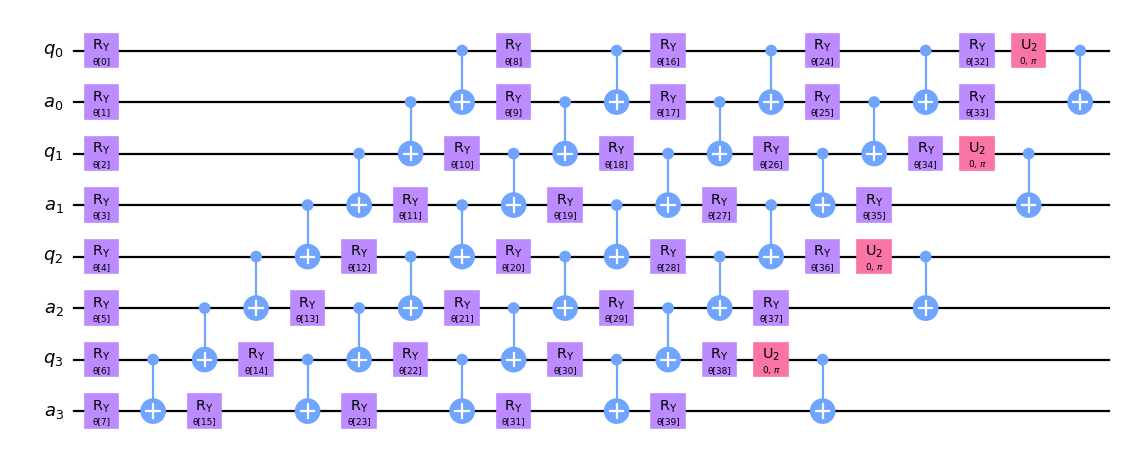

In [3]:
naive_kwargs = {"num_qubits":num_qubits,"depth":4,"entanglement":"reverse_linear","su2_gates":["ry"],"ent_gates":["cx"]}
naive_ansatz,naive_x0 = efficientTwoLocalansatz(**naive_kwargs)
display(print_ansatz(naive_ansatz))

In [4]:
beta = 1.0
problem = TimeEvolutionProblem(hamiltonian = Ho^"I"*num_qubits, time = beta/2)
variational_principle = ImaginaryMcLachlanPrinciple(gradient = ReverseEstimatorGradient(), qgt = ReverseQGT() )


varqite_kwargs = {
"ode_solver" : ForwardEulerSolver,
"num_timesteps" : 10
}

varqite = VarQITE(naive_ansatz,naive_x0, variational_principle=variational_principle, **varqite_kwargs)
result_varqite = varqite.evolve(problem)
naive_result = GibbsResult(
    ansatz_arguments=naive_kwargs,
    parameters=result_varqite.parameter_values,
    coriginal=co,
    num_qubits=num_qubits,
    klocality=2,
    betas=[2 * t for t in result_varqite.times],
    periodic=True,
)

Taking a step beta=0.0
Taking a step beta=0.1
Taking a step beta=0.2
Taking a step beta=0.30000000000000004
Taking a step beta=0.4
Taking a step beta=0.5
Taking a step beta=0.6
Taking a step beta=0.7
Taking a step beta=0.7999999999999999
Taking a step beta=0.8999999999999999


(48,) (48,) (48,)


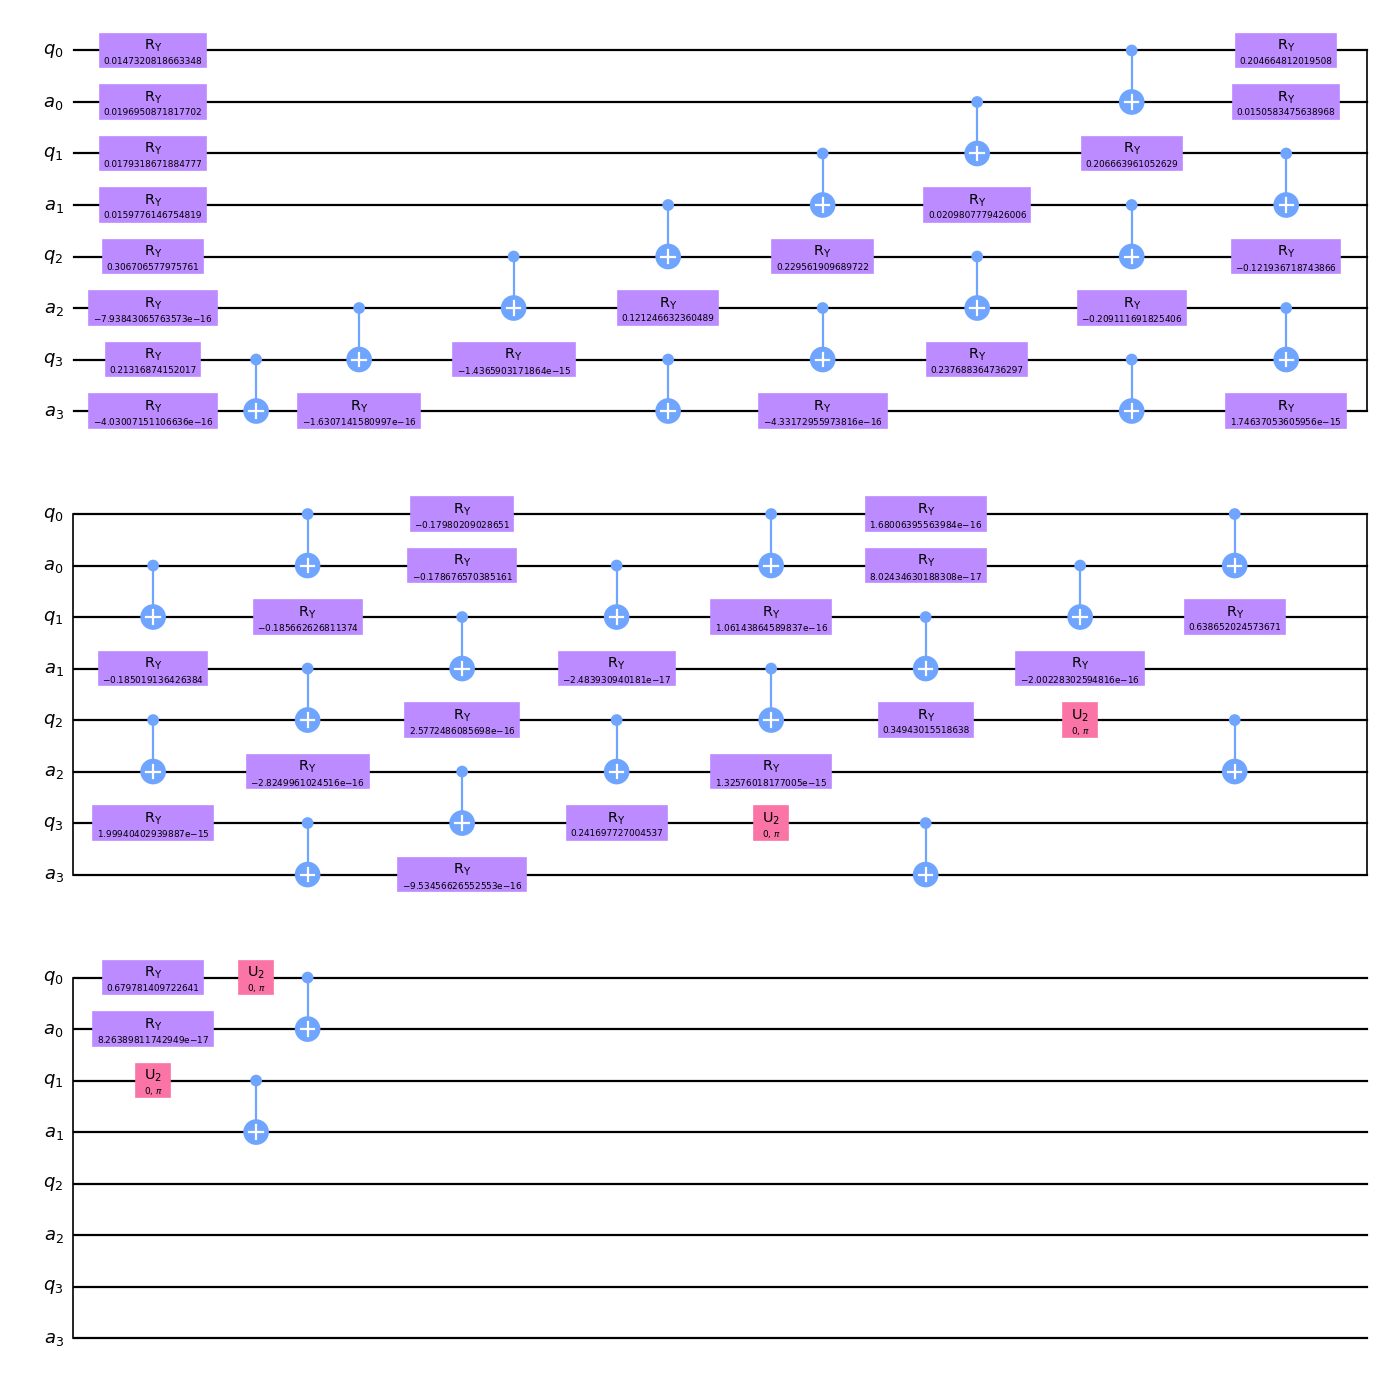

In [5]:
display(preparation(naive_result,-1,True))
display(print_ansatz(naive_result.state))

Now we are going to reuse the parameters of our circuit such that we are guaranteed to conserve symmetry.

theta, ['theta[0]', 'theta[1]', 'theta[2]', 'theta[3]', 'theta[4]', 'theta[5]', 'theta[6]', 'theta[7]', 'theta[8]', 'theta[9]']
10


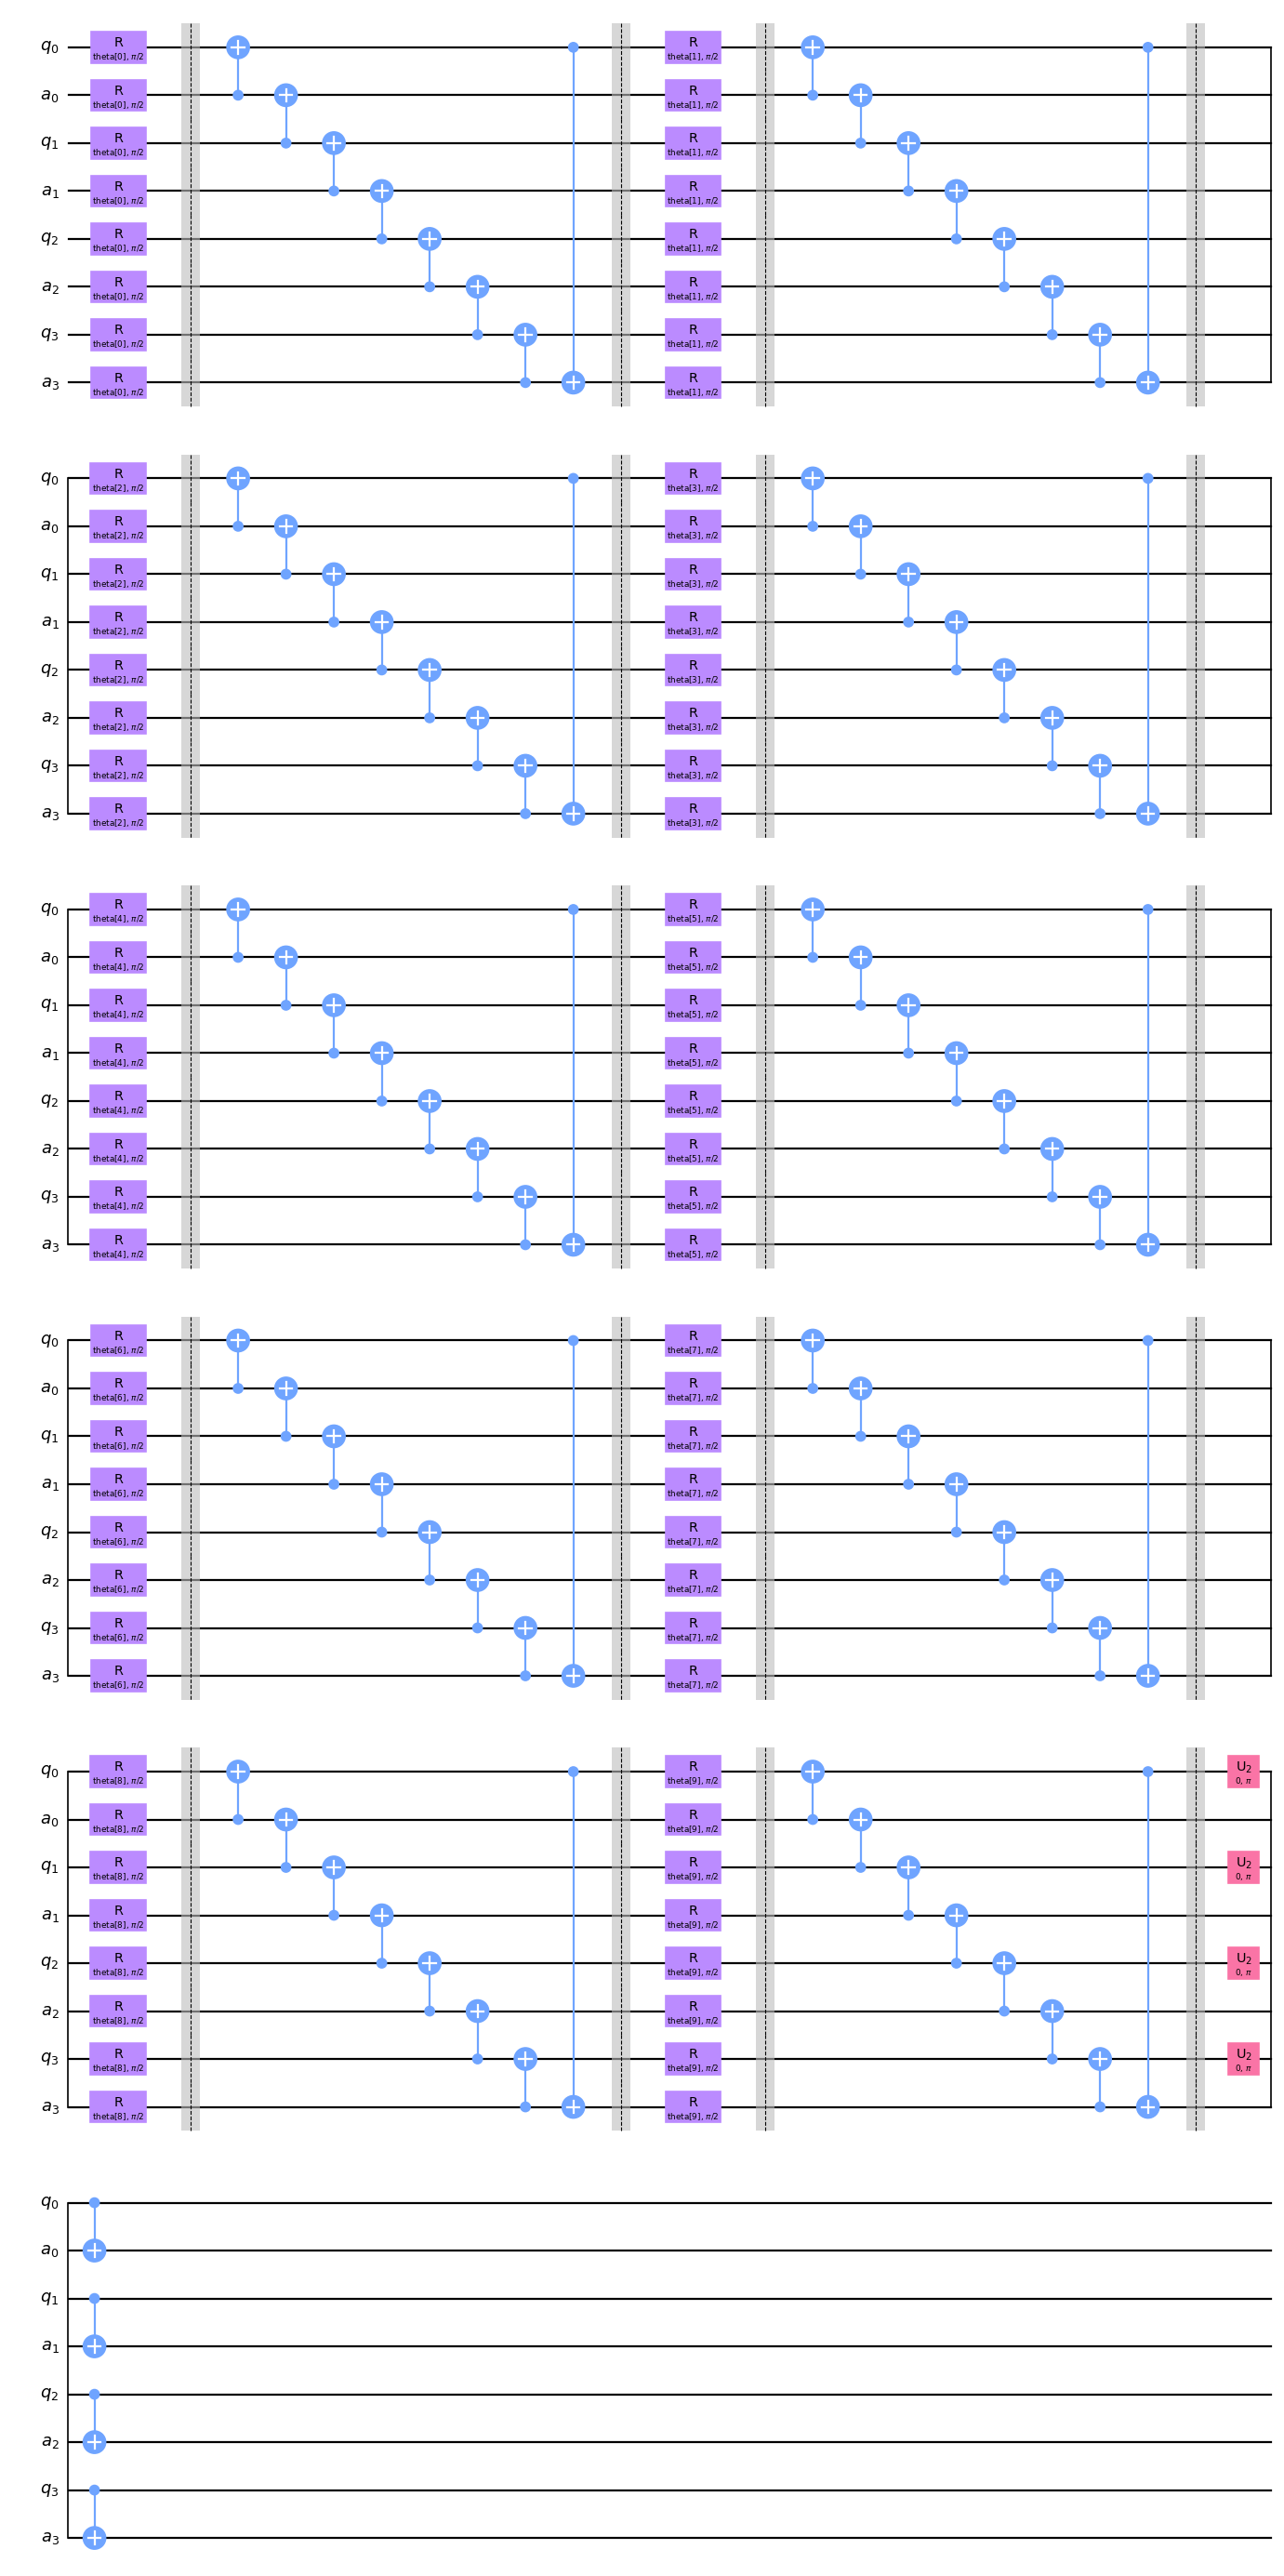

In [32]:
from qiskit.circuit.library import RYGate
from qiskit.circuit import ParameterVector, QuantumCircuit, QuantumRegister

qr = QuantumRegister(num_qubits, name="q")
ancilla = QuantumRegister(num_qubits, name="a")
ansatz = QuantumCircuit(qr, ancilla)
params = ParameterVector("theta",10)

reordered = [None] * num_qubits * 2
reordered[::2] = list(qr)
reordered[1::2] = list(ancilla)
print(params)
for pp in params:
    ansatz.ry(pp,reordered)
    ansatz.barrier()
    ansatz.cx(reordered[1:],reordered[:-1])
    ansatz.cx(reordered[0],reordered[-1])
    ansatz.barrier()
# ansatz.append(eff, qargs=reordered)
# This one is the one that prepares the purification of the identity
ansatz.h(qr)
ansatz.cx(qr, ancilla)

# Set the initial parameters to be the identity
x0_compact = np.zeros(ansatz.num_parameters)
compact_ansatz = ansatz
print(compact_ansatz.num_parameters)
display(print_ansatz(ansatz))

In [33]:
varqite_compact = VarQITE(compact_ansatz,x0_compact, variational_principle=variational_principle, **varqite_kwargs)
result_varqite = varqite_compact.evolve(problem)
compact_result = GibbsResult(
    ansatz_arguments=None,
    parameters=result_varqite.parameter_values,
    coriginal=co,
    num_qubits=num_qubits,
    klocality=2,
    betas=[2 * t for t in result_varqite.times],
    periodic=True,
)

Taking a step beta=0.0
Taking a step beta=0.1
Taking a step beta=0.2
Taking a step beta=0.30000000000000004
Taking a step beta=0.4
Taking a step beta=0.5
Taking a step beta=0.6
Taking a step beta=0.7
Taking a step beta=0.7999999999999999
Taking a step beta=0.8999999999999999


[-0.09234337 -0.03147302  0.26884272  0.15332603 -0.00963499 -0.00049137
  0.016064    0.04552524 -0.0775226  -0.0379893 ]


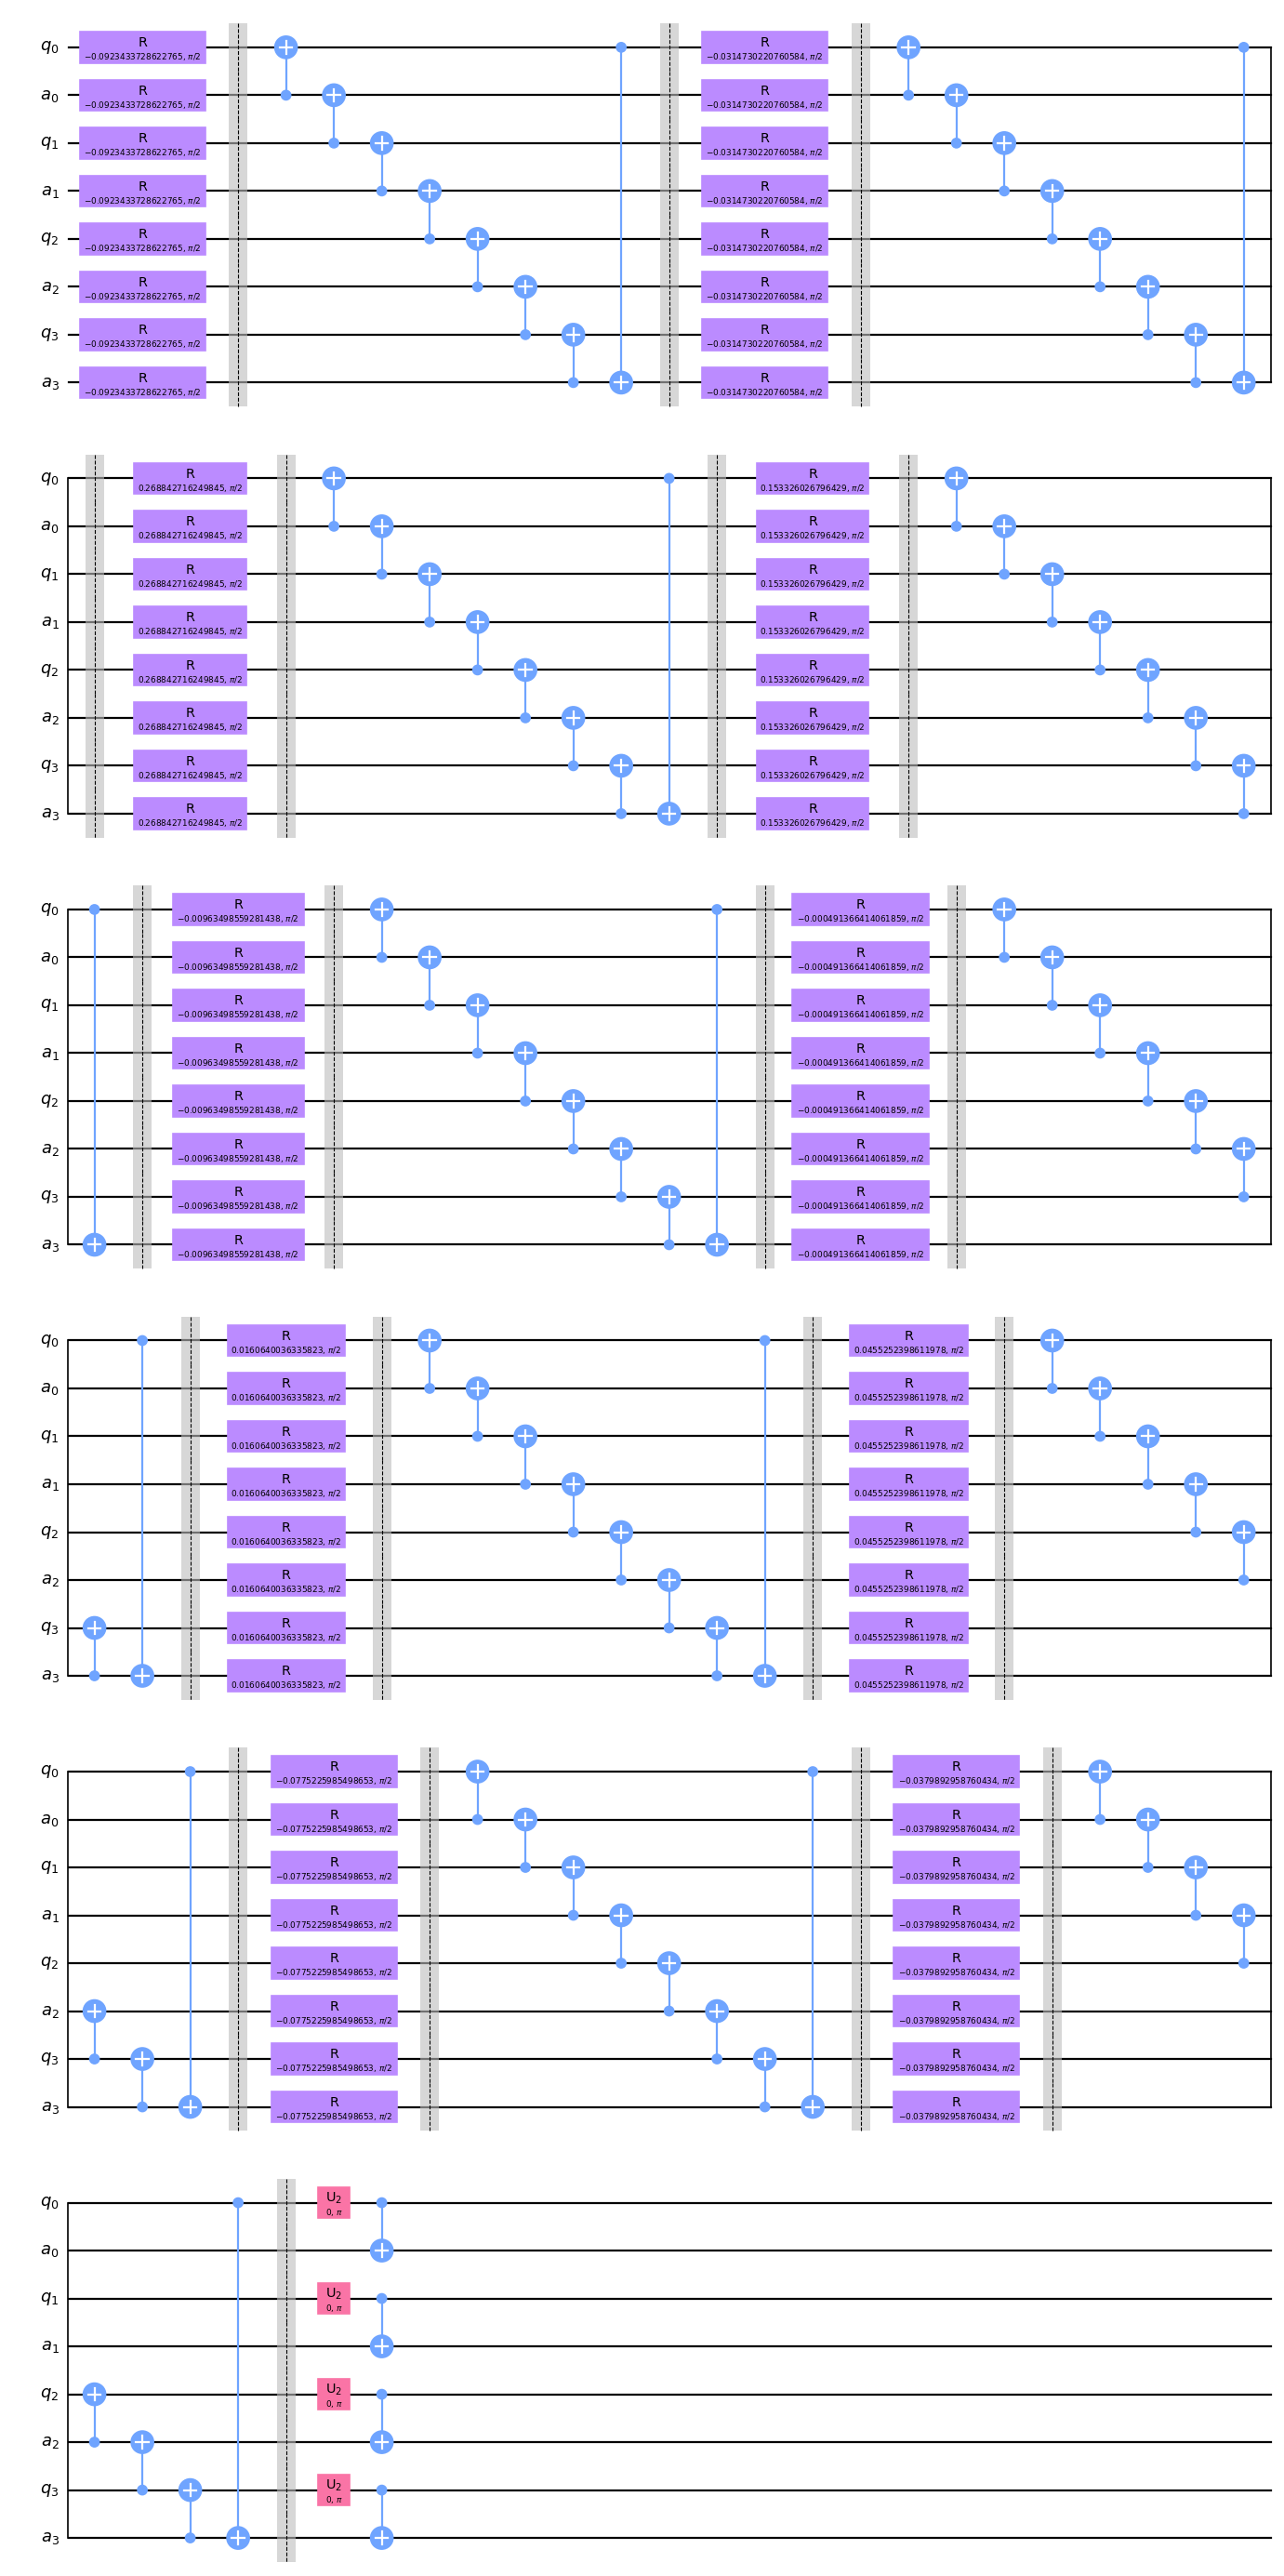

In [34]:
print(compact_result.parameters[-1])
display(print_ansatz(compact_ansatz.bind_parameters(compact_result.parameters[-1])))

In [35]:
import plotly_express as px
from gibbs.utils import classical_learn_hamiltonian
cfaulty = np.real(classical_learn_hamiltonian(compact_ansatz.bind_parameters(compact_result.parameters[-1]),2,True))
px.bar(y=[cfaulty,np.real(co)],barmode="group")

In [47]:
from qiskit.quantum_info import SparsePauliOp
H_temp = SparsePauliOp.from_list([("IIII",1)])
for l in range(1,7):
    H_temp = (H_temp@Ho).simplify()
    print("######################")
    print(len(H_temp.paulis))
    # print(H_temp.paulis)
    print("######################")


######################
16
######################
######################
58
######################
######################
56
######################
######################
64
######################
######################
56
######################
######################
64
######################


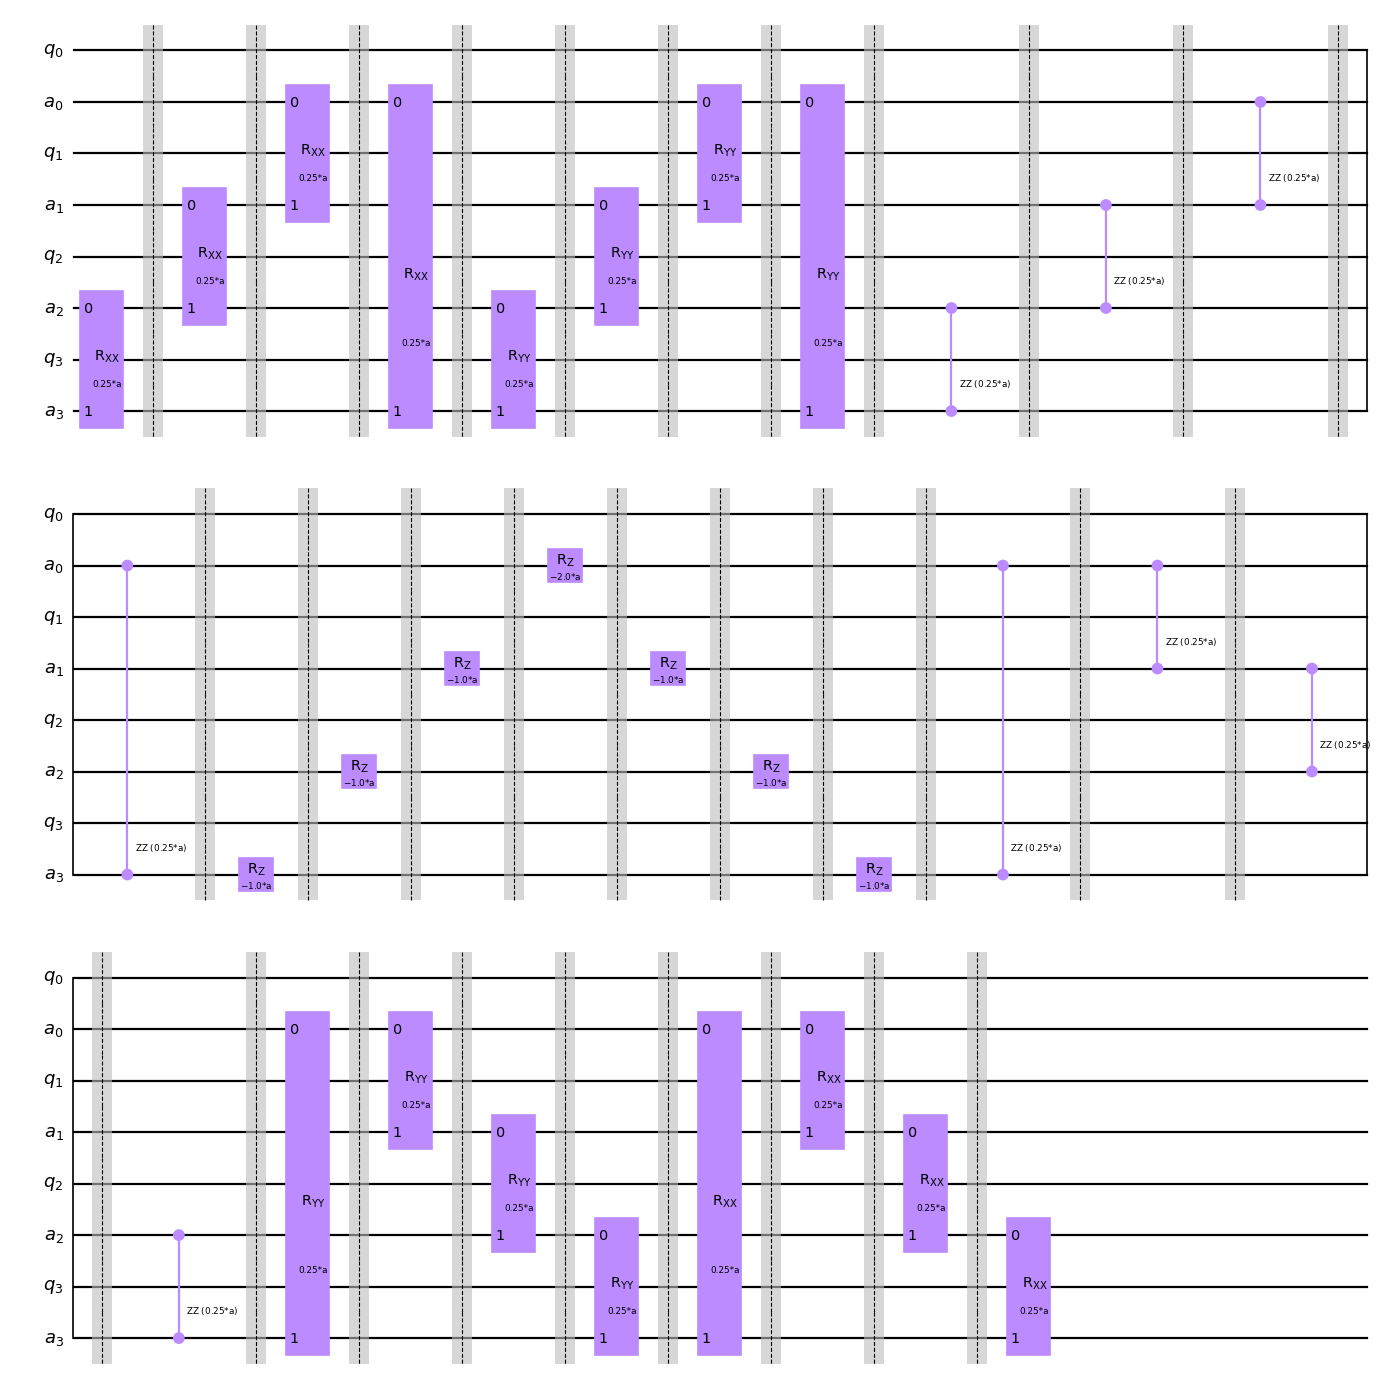

In [72]:
from qiskit.circuit.library.pauli_evolution import PauliEvolutionGate
from qiskit.synthesis.evolution.suzuki_trotter import SuzukiTrotter
from qiskit.circuit import Parameter
qc = QuantumCircuit(qr,ancilla)
qc.append(PauliEvolutionGate(Ho^("I"*num_qubits),Parameter("a"),synthesis=SuzukiTrotter(order=2,reps=1,insert_barriers=True)),list(qr)+list(ancilla))
display(print_ansatz(qc.decompose()))